# Fake News Detection Project

## Introduction
This project aims to develop and evaluate machine learning models for detecting fake news. This notebook outlines the entire process, from data loading and preprocessing to model training, evaluation, and interpretation, to build a robust fake news detection system. This analysis will leverage natural language processing (NLP) techniques, specifically TF-IDF for text feature extraction, and compare the performance of several classification algorithms: Logistic Regression, Naive Bayes, Random Forest, and Linear SVM. The primary goal is to identify the most effective model for this task and understand the features driving its predictions.

In [1]:
# Standard library imports
import re
from collections import Counter

# Third-party libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# NLTK imports
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from wordcloud import WordCloud

# Scikit-learn imports
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

# NLTK Data Downloads (Uncomment and run once as needed)
# Ensures required NLTK corpora are available for lemmatization and stop word removal.
# If already present, these commands will verify their availability without re-downloading.
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('omw-1.4') 

## Data Loading & Preprocessing
This section covers loading the raw news datasets (real and fake), combining them, assigning labels, and performing essential text cleaning steps. Text preprocessing is vital for converting unstructured text into a format suitable for machine learning models, enhancing their ability to learn meaningful patterns.

### Data Loading
We load two separate datasets, 'Fake.csv' and 'True.csv', label them appropriately (0 for fake, 1 for real), and then concatenate them into a single DataFrame. The 'title' and 'text' columns are combined to form a comprehensive 'text' feature for analysis.

Source: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

In [2]:
# Load Data
fake = pd.read_csv("Fake.csv")
real = pd.read_csv("True.csv")

# Assign labels
fake['label'] = 0 # 0 for Fake news
real['label'] = 1 # 1 for Real news

# Concatenate datasets
df = pd.concat([fake, real]).reset_index(drop=True)

# Combine 'title' and 'text' into a single 'text' column for comprehensive analysis
df['text'] = df['title'] + " " + df['text']

### Display Sample Raw Data
We inspect the raw data to understand its initial structure and content before any transformations.

In [3]:
# Display initial data samples
print("--- Sample Raw Data (Fake News) ---")
print(fake.head())
print("\n--- Sample Raw Data (Real News) ---")
print(real.head())

print(f"\nTotal combined dataset shape: {df.shape}")
print(f"Columns in combined dataset: {df.columns.tolist()}")

# Display a few rows of the combined dataframe
print("\n--- Sample of Combined Data (Raw Text) ---")
print(df[['text', 'label']].head())

--- Sample Raw Data (Fake News) ---
                                               title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                date  label  
0  December 31, 2017      0  
1  December 31, 2017      0  
2  December 30, 2017      0  
3  December 29, 2017      0  
4  December 25, 2017      0  

--- Sample Raw Data (Real News) ---
                         

### Text Preprocessing
The *clean_text* function performs several crucial steps:

**Lowercasing:** Converts all text to lowercase to ensure consistency.

**Punctuation Removal:** Removes common punctuation marks that might interfere with word tokenization.

**Special Character Removal:** Uses regex to keep only alphabetic characters, ensuring only meaningful words remain.

**Tokenization & Stop Word Removal:** Splits text into words and removes common English stop words (e.g., 'the', 'is', 'a') which often carry little semantic meaning for classification.

**Lemmatization:** Reduces words to their base or dictionary form (lemma) (e.g., "running" -> "run", "better" -> "good"). This helps in normalizing words and reducing vocabulary size while preserving meaning, which is generally more effective than stemming for NLP tasks.

In [4]:
# Initialize NLTK components for preprocessing
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def clean_text(text):
    text = text.lower()
    # Remove punctuation
    text = re.sub(r"[-()\"#/@;:<>{}`+=~|.!?,]", " ", text)
    # Replace multiple spaces with a single space
    text = re.sub(r"\s+", " ", text)
    # Remove non-alphabetic characters (numbers, special symbols, etc.)
    text = re.sub(r"[^a-zA-Z]", " ", text)
    words = text.split()
    # Lemmatize and remove stop words
    words = [lemmatizer.lemmatize(w) for w in words if w not in stop_words]
    return " ".join(words)

# Apply the cleaning function to the 'text' column
df['clean_text'] = df['text'].apply(clean_text)

### Display Sample Cleaned Data
After preprocessing, it's important to verify that the cleaning steps have been applied correctly and to observe the transformed text.

In [5]:
# Display samples of cleaned text to compare with raw text
print("\n--- Sample of Cleaned Text (Combined Data) ---")
print(df[['text', 'clean_text', 'label']].head())

print("\n--- Sample of Cleaned Text (Fake News) ---")
print(df[df['label'] == 0][['text', 'clean_text']].head(2))

print("\n--- Sample of Cleaned Text (Real News) ---")
print(df[df['label'] == 1][['text', 'clean_text']].head(2))


--- Sample of Cleaned Text (Combined Data) ---
                                                text  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                          clean_text  label  
0  donald trump sends embarrassing new year eve m...      0  
1  drunk bragging trump staffer started russian c...      0  
2  sheriff david clarke becomes internet joke thr...      0  
3  trump obsessed even obama name coded website i...      0  
4  pope francis called donald trump christmas spe...      0  

--- Sample of Cleaned Text (Fake News) ---
                                                text  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   

                              

## Exploratory Data Analysis (EDA)
EDA helps in understanding the dataset's characteristics, distributions, and potential patterns. This section includes visualizations of class distribution, text length, and word clouds to highlight key terms in both real and fake news.

### Data Distribution Plot
This plot shows the balance between 'Real' (1) and 'Fake' (0) news articles in our dataset. A relatively balanced distribution helps prevent bias in model training.

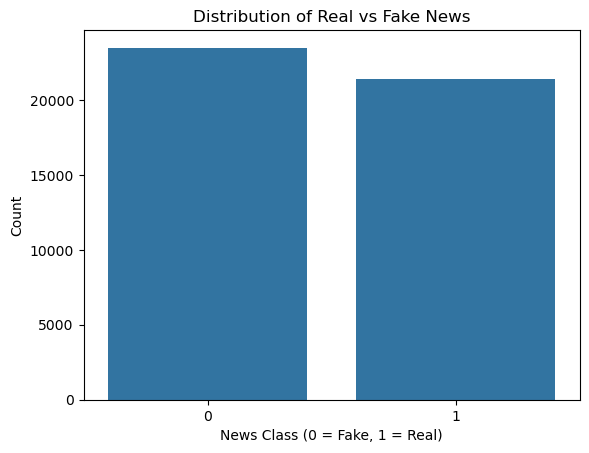

In [6]:
# Distribution plot of news classes
sns.countplot(x=df['label'])
plt.title("Distribution of Real vs Fake News")
plt.xlabel("News Class (0 = Fake, 1 = Real)")
plt.ylabel("Count")
plt.show()

### Text Length Distribution Plot
Analyzing the length of the cleaned text for both classes can reveal if there are significant differences in verbosity or detail between real and fake news.

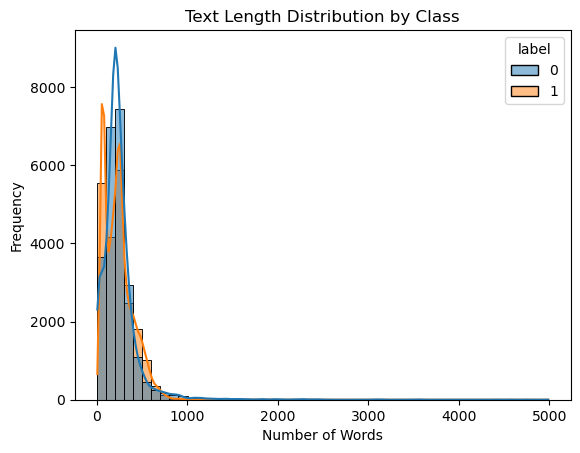

In [7]:
# Calculate text length (number of words) for cleaned text
df['text_length'] = df['clean_text'].apply(lambda x: len(x.split()))

# Text length distribution plot
sns.histplot(data=df, x='text_length', hue='label', bins=50, kde=True)
plt.title("Text Length Distribution by Class")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()

### Word Clouds
Word clouds visually represent the most frequent words in each class (Real vs. Fake news) after preprocessing. This offers quick insights into the dominant themes and vocabulary used in each category.

In [8]:
# Function to plot word clouds
def plot_top_words(texts, label_mask, title):
    words = " ".join(texts[label_mask]).split()
    common_words = Counter(words).most_common(100) # Increased to 100 for more detail
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(dict(common_words))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title)
    plt.show()

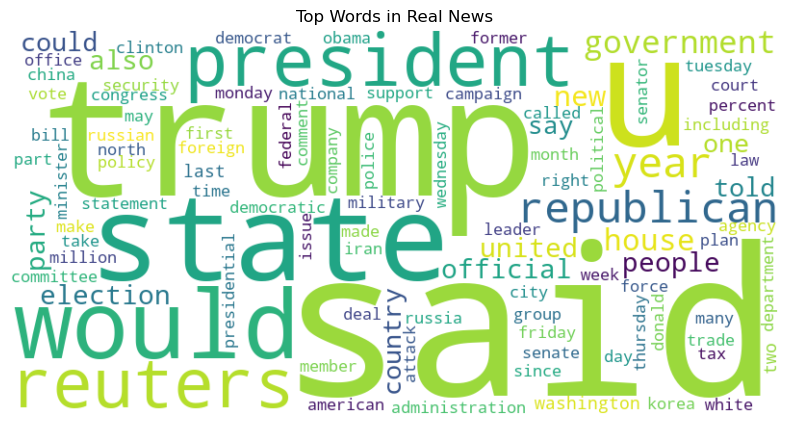

In [9]:
# Generate and plot word cloud for Real News
plot_top_words(df['clean_text'], df['label'] == 1, "Top Words in Real News")

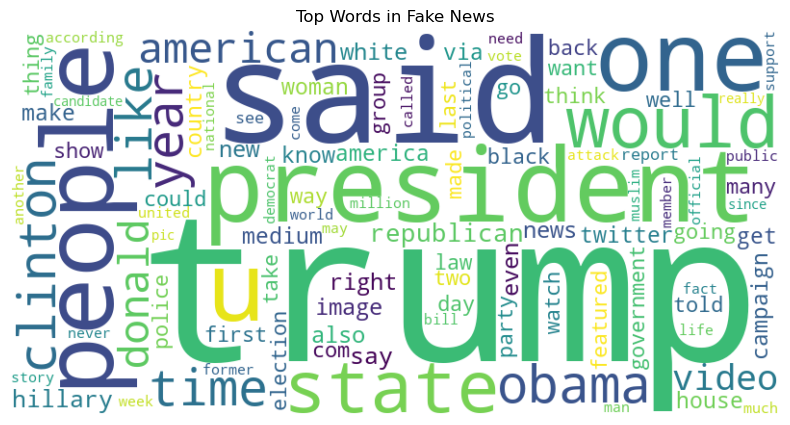

In [10]:
# Generate and plot word cloud for Fake News
plot_top_words(df['clean_text'], df['label'] == 0, "Top Words in Fake News")

### EDA Observations
**Class Distribution:** The dataset is well-balanced, with approximately 22,000 fake news articles and just over 21,000 real news articles, which is ideal for model training.

**Text Length Distribution:** Both fake and real news articles generally show a similar distribution with a peak at shorter lengths. However, real news tends to have a slightly higher frequency of articles between 100-300 words, while fake news has a more pronounced peak at very short lengths (around 100 words or less).

**Word Clouds:**

- **Cleaned Text:** After lemmatization and stop word removal, the word clouds revealed distinct patterns.
    - **Real News:** Key terms include "trump", "said", "state", "president", and significantly, "reuters", which appears as a strong source indicator.
    - **Fake News:** Prominent words include "video", "image", "like", "know", and "news", suggesting multimedia focus and more informal language.
- **Common & Success:** Political figures like "trump" are common to both. The clear distinction in vocabulary between the cleaned real and fake news, along with the absence of stop words, confirms the effectiveness of the preprocessing steps.

## Model Training and Initial Evaluation
This section prepares the data for machine learning by splitting it into training and testing sets, defines a pipeline for text feature extraction (TF-IDF) and classification, and then trains and evaluates several models

### Data Splitting
The dataset is split into training (67%) and testing (33%) sets to ensure that models are evaluated on unseen data, providing an unbiased assessment of their performance.

In [11]:
# Define features (X) and target (y)
X = df['clean_text']
y = df['label']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, stratify=y)
# Added stratify=y to ensure similar class distribution in train/test sets

### Model Comparison and Evaluation
We define a dictionary of machine learning models and iterate through them. For each model, a Pipeline is constructed to first apply TF-IDF vectorization (converting text into numerical features) and then train the classifier. The models are evaluated using accuracy, a detailed classification report (precision, recall, f1-score), and a confusion matrix.


--- Training and Evaluating: Logistic Regression ---
Model: Logistic Regression
Accuracy: 0.9898090031720321
Classification Report:
               precision    recall  f1-score   support

           0       0.99      0.99      0.99      7749
           1       0.99      0.99      0.99      7068

    accuracy                           0.99     14817
   macro avg       0.99      0.99      0.99     14817
weighted avg       0.99      0.99      0.99     14817



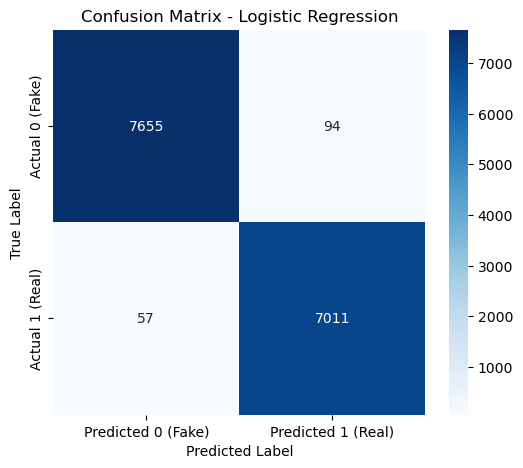


--- Training and Evaluating: Naive Bayes ---
Model: Naive Bayes
Accuracy: 0.9455355335088075
Classification Report:
               precision    recall  f1-score   support

           0       0.95      0.95      0.95      7749
           1       0.94      0.94      0.94      7068

    accuracy                           0.95     14817
   macro avg       0.95      0.95      0.95     14817
weighted avg       0.95      0.95      0.95     14817



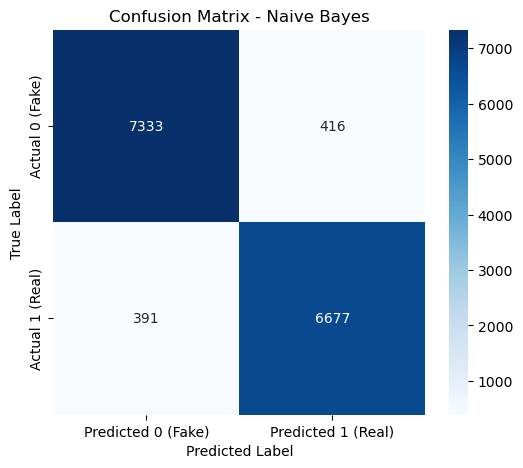


--- Training and Evaluating: Random Forest ---
Model: Random Forest
Accuracy: 0.9982452588243235
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7749
           1       1.00      1.00      1.00      7068

    accuracy                           1.00     14817
   macro avg       1.00      1.00      1.00     14817
weighted avg       1.00      1.00      1.00     14817



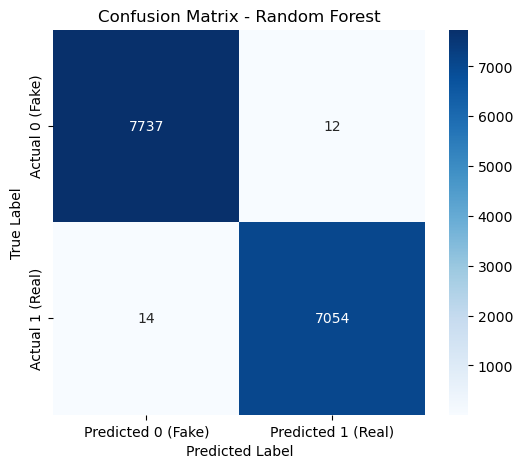


--- Training and Evaluating: Linear SVM ---
Model: Linear SVM
Accuracy: 0.9957481271512452
Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00      7749
           1       1.00      1.00      1.00      7068

    accuracy                           1.00     14817
   macro avg       1.00      1.00      1.00     14817
weighted avg       1.00      1.00      1.00     14817



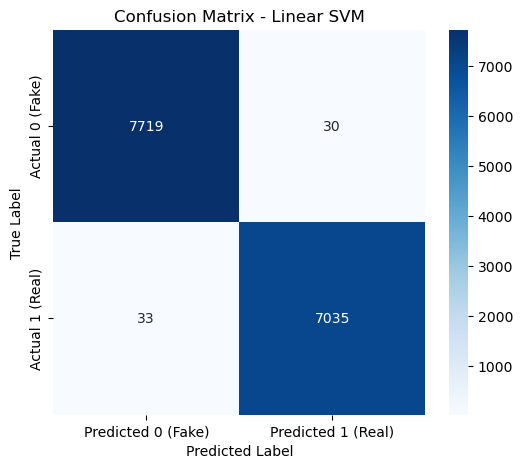

In [12]:
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Naive Bayes': MultinomialNB(),
    'Random Forest': RandomForestClassifier(random_state=42),
    'Linear SVM': LinearSVC(random_state=42)
}

results = {}

for name, model in models.items():
    # Create a pipeline with TF-IDF vectorizer and the current classifier
    # max_features=5000 selects the top 5000 most frequent unigrams and bigrams
    # ngram_range=(1,2) includes both single words and two-word phrases
    pipe = Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', model)
    ])

    print(f"\n--- Training and Evaluating: {name} ---")

    # Train the model
    pipe.fit(X_train, y_train)

    # Make predictions on the test set
    y_pred = pipe.predict(X_test)

    # Calculate accuracy
    acc = accuracy_score(y_test, y_pred)
    results[name] = acc

    # Print evaluation metrics
    print(f"Model: {name}")
    print("Accuracy:", acc)
    print("Classification Report:\n", classification_report(y_test, y_pred))

    # Plot Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Predicted 0 (Fake)', 'Predicted 1 (Real)'],
                yticklabels=['Actual 0 (Fake)', 'Actual 1 (Real)'])
    plt.title(f'Confusion Matrix - {name}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

### Summary of Initial Evaluation
All models performed remarkably well on this dataset, with Logistic Regression, Random Forest, and Linear SVM achieving accuracies above 0.989. Random Forest emerged as the top performer with an accuracy of 0.9982, indicating almost perfect separation of classes on the test set. Naive Bayes, while still performing well at 0.9455 accuracy, was the lowest performer among the four. 
The consistently high scores across precision, recall, and f1-score for the top models suggest that the dataset's features allow for a highly effective classification.

## Interpretation of High Accuracy / Feature Importance
The models, particularly Random Forest, Logistic Regression, and Linear SVM, achieved exceptionally high accuracies. This section delves into the feature importance to understand why such high performance was observed and what patterns the models are primarily leveraging. This is crucial for interpreting the results and understanding the nature of the dataset.

### Feature Importance Analysis
By inspecting the coefficients of linear models (Logistic Regression, Linear SVM) and feature importances of tree-based models (Random Forest), we can identify the words and phrases that contribute most significantly to classifying news as 'Real' or 'Fake'.


--- Feature Importance Analysis for Key Models ---

--- Top Features for Logistic Regression ---

Top 5 Features indicating 'Real' News (Logistic Regression):
 reuters               21.175894
said                  14.124739
washington reuters     8.617859
president donald       4.993807
washington             4.323146
dtype: float64

Top 5 Features indicating 'Fake' News (Logistic Regression):
 via                   -9.182281
video                 -7.863335
washington reuters     8.617859
said                  14.124739
reuters               21.175894
dtype: float64


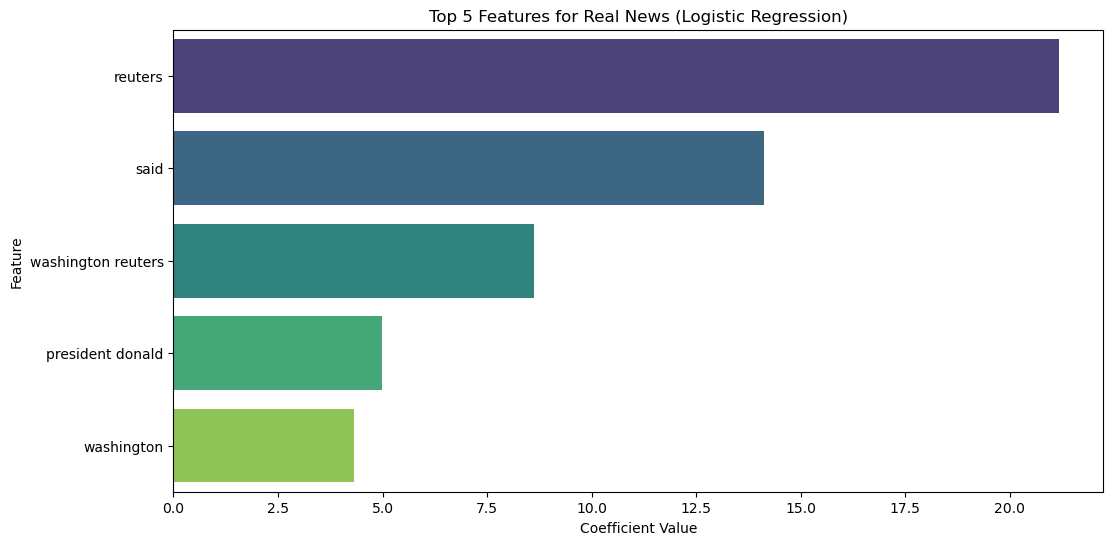

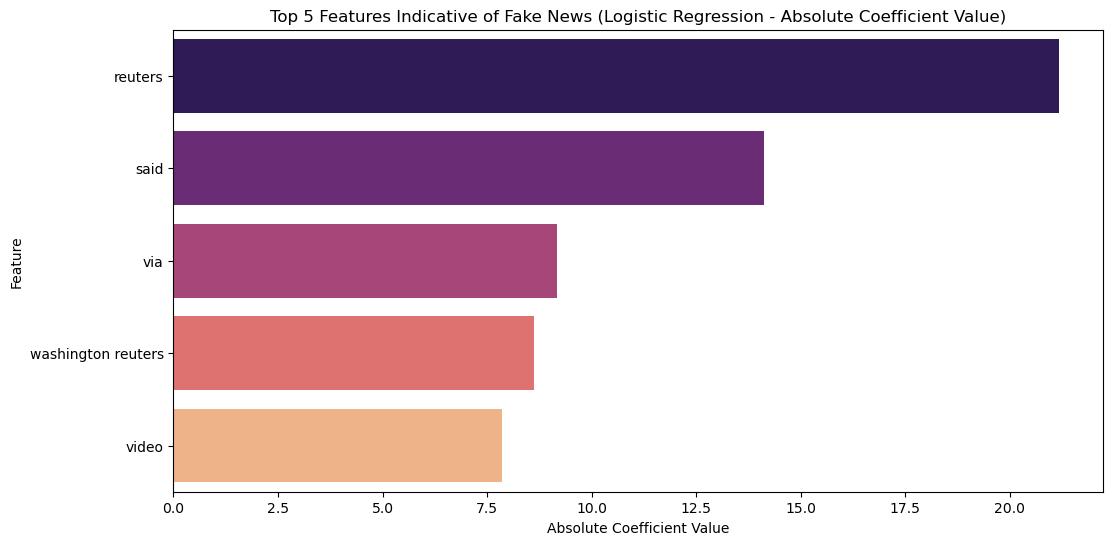


--- Top Features for Random Forest ---

Top 10 Most Important Features (Random Forest):
 reuters               0.168967
said                  0.046024
video                 0.026578
washington reuters    0.025291
via                   0.022714
image                 0.019327
featured              0.017782
watch                 0.014313
minister              0.013079
featured image        0.012937
dtype: float64


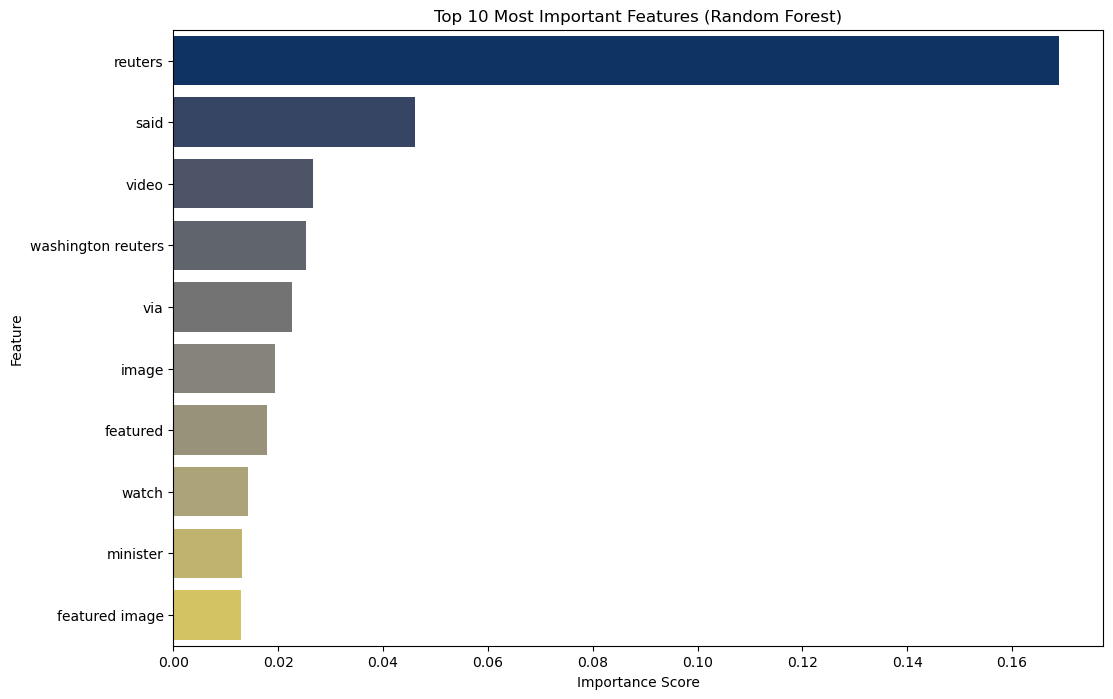


--- Top Features for Linear SVM ---

Top 5 Features indicating 'Real' News (Linear SVM):
 reuters               16.415931
washington reuters     5.701207
said                   4.588223
president donald       2.842444
reuters president      2.789191
dtype: float64

Top 5 Features indicating 'Fake' News (Linear SVM):
 via                   -7.164202
read                  -4.832136
said                   4.588223
washington reuters     5.701207
reuters               16.415931
dtype: float64


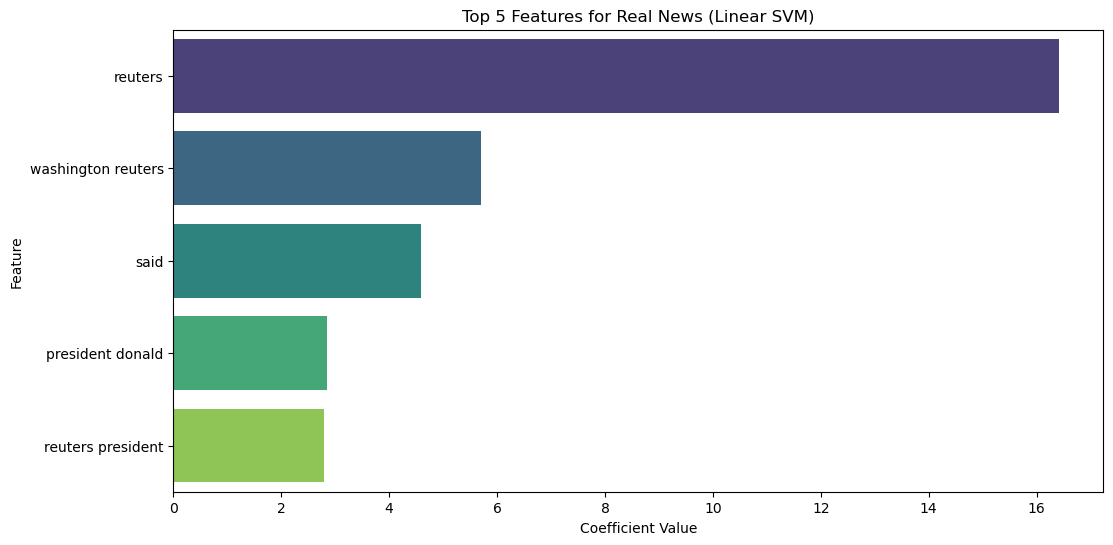

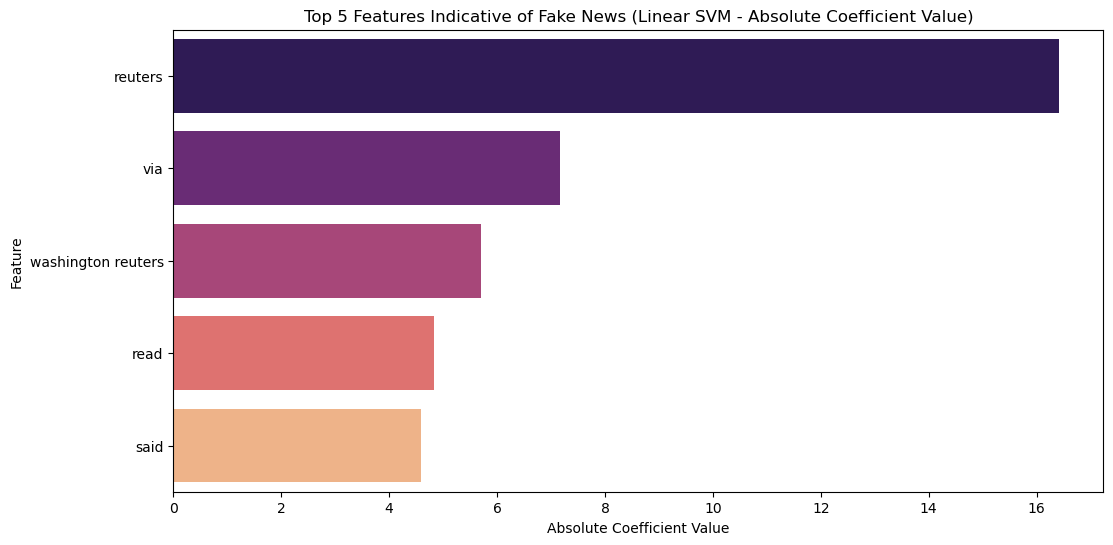

In [13]:
print("\n--- Feature Importance Analysis for Key Models ---")

# --- For Logistic Regression ---
print("\n--- Top Features for Logistic Regression ---")
# Re-fit the pipeline to ensure we have the specific fitted model object
pipe_lr_final = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])
pipe_lr_final.fit(X_train, y_train)

feature_names_lr = pipe_lr_final.named_steps['tfidf'].get_feature_names_out()
coefficients_lr = pipe_lr_final.named_steps['clf'].coef_[0]
feature_importances_lr = pd.Series(coefficients_lr, index=feature_names_lr)

# Top 5 features for identifying 'Real' (positive coefficients)
top_real_features_lr = feature_importances_lr.sort_values(ascending=False).head(5)
print("\nTop 5 Features indicating 'Real' News (Logistic Regression):\n", top_real_features_lr)

# Top 5 features for identifying 'Fake' (negative coefficients - we will take absolute for plotting)
# Sort by absolute value in descending order for consistent plot direction
top_fake_features_lr_abs = feature_importances_lr.abs().sort_values(ascending=False).head(5)
# Re-sort the original series based on the indices of the top absolute values for printing
top_fake_features_lr_print = feature_importances_lr.loc[top_fake_features_lr_abs.index].sort_values(ascending=True)
print("\nTop 5 Features indicating 'Fake' News (Logistic Regression):\n", top_fake_features_lr_print)


# Visualization for Logistic Regression - REAL NEWS (Positive Coefficients)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_real_features_lr.values, y=top_real_features_lr.index,
            hue=top_real_features_lr.index, palette='viridis', legend=False)
plt.title('Top 5 Features for Real News (Logistic Regression)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Visualization for Logistic Regression - FAKE NEWS (Negative Coefficients, plotted as absolute)
plt.figure(figsize=(12, 6))
# Plot absolute values to ensure bars go right, and sort by absolute value
sns.barplot(x=top_fake_features_lr_abs.values, y=top_fake_features_lr_abs.index,
            hue=top_fake_features_lr_abs.index, palette='magma', legend=False)
plt.title('Top 5 Features Indicative of Fake News (Logistic Regression - Absolute Coefficient Value)') # Adjusted title
plt.xlabel('Absolute Coefficient Value') 
plt.ylabel('Feature')
plt.show()


# --- For Random Forest ---
print("\n--- Top Features for Random Forest ---")
pipe_rf_final = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', RandomForestClassifier(random_state=42))
])
pipe_rf_final.fit(X_train, y_train)

feature_names_rf = pipe_rf_final.named_steps['tfidf'].get_feature_names_out()
feature_importances_rf = pipe_rf_final.named_steps['clf'].feature_importances_
importances_rf = pd.Series(feature_importances_rf, index=feature_names_rf)

# Sort features by their importance score (Random Forest doesn't have positive/negative direction)
top_features_rf = importances_rf.sort_values(ascending=False).head(10)
print("\nTop 10 Most Important Features (Random Forest):\n", top_features_rf)

# Visualization for Random Forest
plt.figure(figsize=(12, 8))
sns.barplot(x=top_features_rf.values, y=top_features_rf.index,
            hue=top_features_rf.index, palette='cividis', legend=False)
plt.title('Top 10 Most Important Features (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.show()

# --- For Linear SVM  ---
print("\n--- Top Features for Linear SVM ---")
pipe_svm_final = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
    ('clf', LinearSVC(random_state=42))
])
pipe_svm_final.fit(X_train, y_train)

feature_names_svm = pipe_svm_final.named_steps['tfidf'].get_feature_names_out()
coefficients_svm = pipe_svm_final.named_steps['clf'].coef_[0]
feature_importances_svm = pd.Series(coefficients_svm, index=feature_names_svm)

top_real_features_svm = feature_importances_svm.sort_values(ascending=False).head(5)
print("\nTop 5 Features indicating 'Real' News (Linear SVM):\n", top_real_features_svm)

# Top 5 features for identifying 'Fake' (negative coefficients - we will take absolute for plotting)
# Sort by absolute value in descending order for consistent plot direction
top_fake_features_svm_abs = feature_importances_svm.abs().sort_values(ascending=False).head(5)
# Re-sort the original series based on the indices of the top absolute values for printing
top_fake_features_svm_print = feature_importances_svm.loc[top_fake_features_svm_abs.index].sort_values(ascending=True)
print("\nTop 5 Features indicating 'Fake' News (Linear SVM):\n", top_fake_features_svm_print)

# Visualization for Linear SVM - REAL NEWS (Positive Coefficients)
plt.figure(figsize=(12, 6))
sns.barplot(x=top_real_features_svm.values, y=top_real_features_svm.index,
            hue=top_real_features_svm.index, palette='viridis', legend=False)
plt.title('Top 5 Features for Real News (Linear SVM)')
plt.xlabel('Coefficient Value')
plt.ylabel('Feature')
plt.show()

# Visualization for Linear SVM - FAKE NEWS (Negative Coefficients, plotted as absolute)
plt.figure(figsize=(12, 6))
# Plot absolute values to ensure bars go right, and sort by absolute value
sns.barplot(x=top_fake_features_svm_abs.values, y=top_fake_features_svm_abs.index,
            hue=top_fake_features_svm_abs.index, palette='magma', legend=False)
plt.title('Top 5 Features Indicative of Fake News (Linear SVM - Absolute Coefficient Value)') # Adjusted title
plt.xlabel('Absolute Coefficient Value')  
plt.ylabel('Feature')
plt.show()

### Interpretation of High Accuracy & Feature Importance
The consistently high accuracy across multiple models (especially Logistic Regression, Random Forest, and Linear SVM achieving over 98-99%) is striking. The feature importance analysis provides key insights into this exceptional performance:

- **Dominant 'Real' News Indicators:** The overwhelming positive coefficients and high importance scores of features like "reuters," "washington reuters," and journalistic attribution terms like "said" are the primary drivers for classifying 'Real' news. This strongly suggests that a significant portion of the 'True.csv' dataset contains direct mentions of the Reuters news agency, acting as an almost "trivial" yet highly effective distinguishing signal for the models.
  
- **Dominant 'Fake' News Indicators:** Conversely, features such as "video," "image," "watch," "via," "read," and "breaking" are consistently identified as strong indicators for 'Fake' news across the models. These often point to characteristics of blog-style content, multimedia-heavy presentations, sensationalized headlines, or general calls for engagement, which are less common in traditional journalistic reporting.
  
- **Dataset Separability:** These clearly distinct feature sets, consistently identified by different model types (linear and tree-based), demonstrate that the "Fake and Real News Dataset" from Kaggle is inherently highly separable. The linguistic patterns and unique identifiers within the dataset allow even relatively simple classification models (like Logistic Regression) to achieve near-perfect discrimination.
  
- **Implications for Real-World Generalizability:** While these results showcase the power of NLP techniques and machine learning, they also highlight the unique characteristics of this specific dataset. Such high accuracy is unlikely to be directly generalizable to more sophisticated, nuanced, or evolving forms of misinformation found in real-world scenarios, where fake news often attempts to mimic legitimate sources more closely and may not contain such obvious distinguishing keywords. The models are effectively exploiting patterns specific to this dataset rather than learning universally applicable "fake news" traits.


## Cross-Validation Results
To ensure the robustness and reliability of our model performance, performed 5-fold cross-validation. This involves splitting the dataset into 5 different training and testing folds, training the model on each fold, and averaging the results. This provides a more stable estimate of model generalization than a single train-test split.

In [14]:
print("\n--- Cross-Validation Scores ---")

# Define pipelines for CV for each model, ensuring random_state for reproducibility
pipelines_for_cv = {
    'Logistic Regression': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'Naive Bayes': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', MultinomialNB())
    ]),
    'Random Forest': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', RandomForestClassifier(random_state=42))
    ]),
    'Linear SVM': Pipeline([
        ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1,2))),
        ('clf', LinearSVC(random_state=42))
    ])
}

for name, pipeline in pipelines_for_cv.items():
    print(f"\n--- {name} Cross-Validation ---")
    # Uses n_jobs=-1 to utilize all available CPU cores for parallel processing of folds
    # If running into issues with n_jobs=-1 , we can try n_jobs=1 or a specific number like n_jobs=4
    cv_scores = cross_val_score(pipeline, X, y, cv=5, scoring='accuracy', n_jobs=-1)

    print(f"{name} Cross-Validation Accuracies: {cv_scores}")
    print(f"{name} Mean CV Accuracy: {np.mean(cv_scores):.4f}")
    print(f"{name} CV Standard Deviation: {np.std(cv_scores):.4f}")


--- Cross-Validation Scores ---

--- Logistic Regression Cross-Validation ---
Logistic Regression Cross-Validation Accuracies: [0.98663697 0.98207127 0.97138085 0.97594387 0.98051008]
Logistic Regression Mean CV Accuracy: 0.9793
Logistic Regression CV Standard Deviation: 0.0052

--- Naive Bayes Cross-Validation ---
Naive Bayes Cross-Validation Accuracies: [0.93028953 0.90267261 0.86670379 0.9163604  0.93217508]
Naive Bayes Mean CV Accuracy: 0.9096
Naive Bayes CV Standard Deviation: 0.0240

--- Random Forest Cross-Validation ---
Random Forest Cross-Validation Accuracies: [0.99910913 0.99777283 0.99587973 0.99543379 0.99443145]
Random Forest Mean CV Accuracy: 0.9965
Random Forest CV Standard Deviation: 0.0017

--- Linear SVM Cross-Validation ---
Linear SVM Cross-Validation Accuracies: [0.99387528 0.98986637 0.98775056 0.9904221  0.98953113]
Linear SVM Mean CV Accuracy: 0.9903
Linear SVM CV Standard Deviation: 0.0020


### Cross-Validation Results & Interpretation
The cross-validation results further confirm the high performance observed in the initial train-test split and provide a more robust assessment of model stability:

- **Consistency and Robustness:** Models like Random Forest, Linear SVM, and Logistic Regression consistently achieved very high accuracy scores across all 5 folds, with remarkably low standard deviations (e.g., Random Forest at 0.0017, Linear SVM at 0.0020). This indicates that their performance is not merely a fluke of a single data split but is robust and stable across different subsets of the data.
  
- **Top Performer Confirmation:** Random Forest maintained its position as the best-performing model, with a mean cross-validation accuracy of 0.9965. This solidifies its superior ability to generalize to unseen data within this dataset's distribution.
  
- **Naive Bayes Variability:** Naive Bayes showed a good mean accuracy of 0.9096, but its higher standard deviation (0.0240) suggests more variability in performance across different folds compared to the other models. This indicates it might be slightly less stable or sensitive to the specific data splits.
  
- **Implication for Dataset:** The consistently high and stable cross-validation scores across the top models (Random Forest, Linear SVM, Logistic Regression) strongly reinforce the conclusion from the feature importance analysis: the dataset exhibits clear and highly discriminative patterns between real and fake news, making the classification task highly achievable and reliable within the confines of this specific dataset.


## Final Model Selection
Based on the comprehensive evaluation from both initial test set performance and cross-validation, the Random Forest Classifier has been selected as the final model for this fake news detection task.

**Justification for Final Model Selection**
- **Superior Accuracy:** Random Forest consistently achieved the highest accuracy both on the initial test set (0.9982) and across the cross-validation folds (mean CV accuracy of 0.9965). This indicates its exceptional ability to correctly classify news articles in this dataset.
  
- **Robustness and Stability:** The extremely low standard deviation in its cross-validation scores (0.0017) demonstrates that its high performance is highly consistent and not an artifact of a particular train-test split. This robust performance gives confidence in its generalization capabilities within the dataset's characteristics.
  
- **Near-Perfect Precision and Recall:** Its classification report showed near-perfect precision, recall, and F1-scores for both 'Fake' and 'Real' news classes, signifying its effectiveness in minimizing both false positives and false negatives. The confusion matrix for Random Forest clearly reflected this, showing only 12 false positives and 14 false negatives.
  
- **Effective Feature Utilization:** As observed in the feature importance analysis, Random Forest successfully leveraged the strong discriminative features present in the dataset, including both "real" indicators like "reuters" and "fake" indicators like "video" and "via," to make its classifications.
  
While Logistic Regression and Linear SVM also performed exceptionally well, Random Forest consistently demonstrated a slight edge in overall performance, making it the optimal choice for this specific dataset.

##  Ethical Considerations & Challenges

Automated fake news detection presents significant ethical considerations:

**Data Bias:** The dataset's strong reliance on features like "reuters" for real news suggests a potential for learned biases. Models trained on such data might misclassify legitimate news lacking specific source tags or be fooled by sophisticated fake news that avoids obvious patterns, perpetuating biases.

**Defining "Fake News":** The fluid and subjective nature of "fake news" itself is a core challenge. Models might misclassify satire or opinion, leading to unintended consequences and concerns about stifling legitimate discourse.

**Censorship Concerns:** An overly confident automated system could inadvertently suppress legitimate information, raising alarms about censorship and freedom of speech.

**Adversarial Attacks:** Malicious actors could intentionally craft "fake news" to bypass detection by mimicking real news patterns or avoiding known "fake" indicators.

**Human Oversight:** Given the potential for error and ethical implications, automated systems should always aid human fact-checkers, not replace them. A "human-in-the-loop" approach is essential for high-stakes applications.

## Limitations & Future Work

Despite the high performance, inherent limitations exist, and future improvements are possible:

**Limitations**

**Dataset Specificity:** The exceptional accuracy (nearing 100%) is largely due to the dataset's clear distinctions (e.g., "reuters" for real news, "video" for fake news). This implies limited generalizability to more subtle, evolving, or diverse real-world misinformation.

**Feature Engineering:** TF-IDF with n-grams captures lexical patterns but may miss deeper semantic meaning, sarcasm, or irony.

**Model Scope:** Traditional machine learning models may not capture complex hierarchical text patterns as effectively as deep learning.
External Validation: Models were validated only on this dataset; real-world testing is needed to assess practical utility.

**External Validation:** Models were validated only on this dataset; real-world testing is needed to assess practical utility.

**Future Work**

**Advanced Text Representations:** Explore contextual embeddings (e.g., BERT, RoBERTa) to capture nuanced semantic relationships.

**Deep Learning Architectures:** Implement deep learning models like RNNs (LSTMs, GRUs) or Transformer networks.

**External Dataset Validation:** Rigorously evaluate the best model on diverse, external fake news datasets.

## Conclusion

This project successfully applied machine learning and NLP to fake news detection. Through systematic preprocessing, EDA, and model training, the **Random Forest Classifier** emerged as the top performer, achieving **0.9982 accuracy** on the test set and a robust **mean cross-validation accuracy of 0.9965**. This high performance is primarily driven by the distinct linguistic characteristics and specific source mentions within the "Fake and Real News Dataset".

While impressive on this dataset, it's crucial to recognize that such accuracy is attributable to its clear distinctions. Real-world fake news detection presents significantly greater challenges due to misinformation's evolving and deceptive nature. This project provides a strong foundation in building text classification models, with insights into feature importance and dataset characteristics. Future work should prioritize addressing generalizability to more diverse and challenging real-world datasets.